# 6002 Project

### Antoniadis Christoforos , Kontoudakis Nikolaos, Tsamoura Evgenia 

In [4]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from itertools import product
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from typing import List
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import BernoulliNB

warnings.filterwarnings('ignore')

In [5]:
# change the following on your pc!
projectPath = "/home/nikos/Documents/6002_project"
# projectPath = "C:/Users/Chris/Downloads"
dataPath = projectPath + "/smp500.csv"

In [6]:
smp500 = pd.read_csv(dataPath, sep= ',', header= 0, names=["date",	"open",	"high",	"low", "close",	"adj. close", "volume"])
smp500 = smp500.drop(columns = ["adj. close"])
smp500['date'] = pd.to_datetime(smp500['date'])

# set date as key
smp500= smp500.set_index(smp500['date']).sort_index().to_period('D').drop(columns = 'date')
smp500

,open,high,low,close,volume
date,,,,,
2022-01-03,4778.14,4796.64,4758.17,4796.56,3831020000
2022-01-04,4804.51,4818.62,4774.27,4793.54,4683170000
2022-01-05,4787.99,4797.70,4699.44,4700.58,4887960000
2022-01-06,4693.39,4725.01,4671.26,4696.05,4295280000
2022-01-07,4697.66,4707.95,4662.74,4677.03,4181510000
...,...,...,...,...,...
2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000
2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000
2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000


### Data validation

In [8]:
print("There are %s na values" %(smp500.isna().sum().sum()))
print("There are %s zero values" % (smp500[smp500 == 0].sum(numeric_only=True).sum()))

# Check inconsistencies
# at every row low must be the lowest value
print("There are %s rows that the low of the row is higher than any other value" % (smp500[(smp500.low> smp500.high) & (smp500.low> smp500.close) & (smp500.low > smp500.open)].sum(numeric_only=True).sum()))

There are 0 na values
There are 0.0 zero values
There are 0.0 rows that the low of the row is higher than any other value


### Outlier Detection

In [10]:
#check the values of each row per specific column for outliers
def identifyOutliers(columnName):
    Zsmp500 = (smp500[columnName] - np.mean(smp500[columnName])) / np.std(smp500[columnName])
    return Zsmp500[(Zsmp500 > 3 ) | (Zsmp500 < -3 )].index
    
# run the function for every column
# smp500= smp500.drop(removeOutliers('open'), axis= 0).drop(removeOutliers('high'), axis= 0).drop(removeOutliers('low'), axis= 0).drop(removeOutliers('close'), axis= 0).drop(removeOutliers('volume'), axis= 0)

print(identifyOutliers('open'))
print(identifyOutliers('high'))
print(identifyOutliers('low'))
print(identifyOutliers('close'))
print(identifyOutliers('volume'))

PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex(['2022-01-24', '2022-02-24', '2022-03-07', '2022-03-08',
             '2022-03-18', '2022-05-31', '2022-06-17', '2022-06-24',
             '2022-09-16', '2022-12-16', '2023-03-17', '2023-06-16',
             '2023-09-15', '2023-12-15', '2024-03-15', '2024-06-21',
             '2024-06-28', '2024-09-20'],
            dtype='period[D]', name='date')


### Ploting

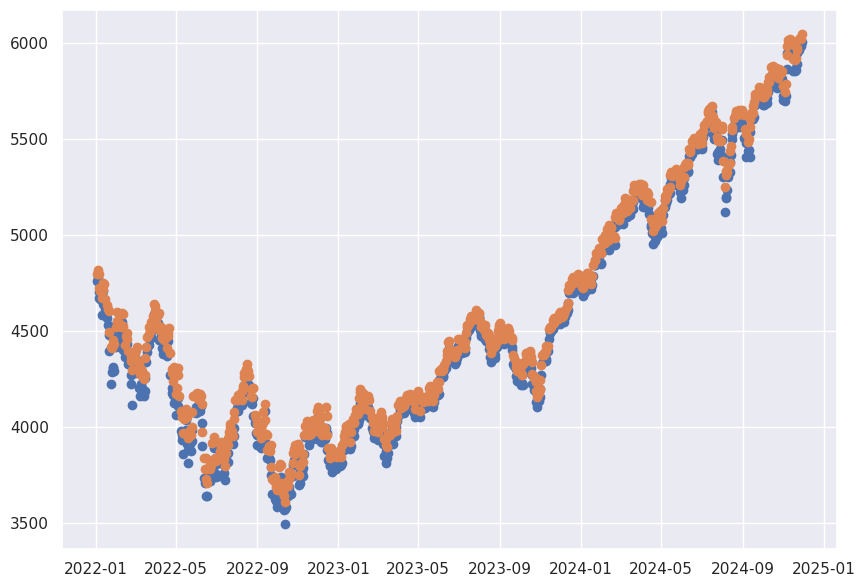

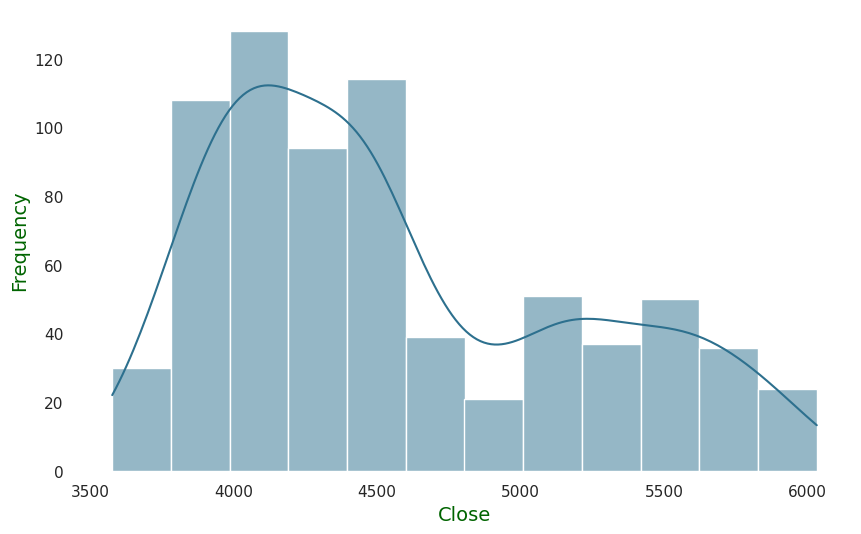

In [12]:
#scater plot
plt.figure(figsize=(10, 7))
plt.scatter(y= smp500.low, x =smp500.index.to_timestamp())
plt.scatter(y= smp500.high, x =smp500.index.to_timestamp())

# histogram
sns.set(style="white")
colors = sns.color_palette("viridis", n_colors=10)

# plotting the SAT score distribution using Seaborn with a KDE (Kernel Density Estimate) plot
plt.figure(figsize=(10, 6))
# sns.histplot(smp500.open, kde=True, color=colors[0])
# sns.histplot(smp500.close, kde=True, color=colors[1])
# sns.histplot(smp500.high, kde=True, color=colors[2])
sns.histplot(smp500.close, kde=True, color=colors[3])
# sns.histplot(smp500.volume, kde=True, color=colors[3])

# Remove left and bottom spines to eliminate the box
sns.despine(left=True, bottom=True)

# set the title and labels
# plt.title("SAT Score Distribution", fontsize=18, color='darkgreen')
plt.xlabel("Close", fontsize=14, color='darkgreen')
plt.ylabel("Frequency", fontsize=14, color='darkgreen')


# display the plot
plt.show()

In [13]:
df = smp500.copy()

In [14]:
# Check numerical columns
num_cols = df.describe(exclude='object') #check numerical columns only
col_names = num_cols.columns # we are using these numerical columns for visualizing our boxplot
# col_names

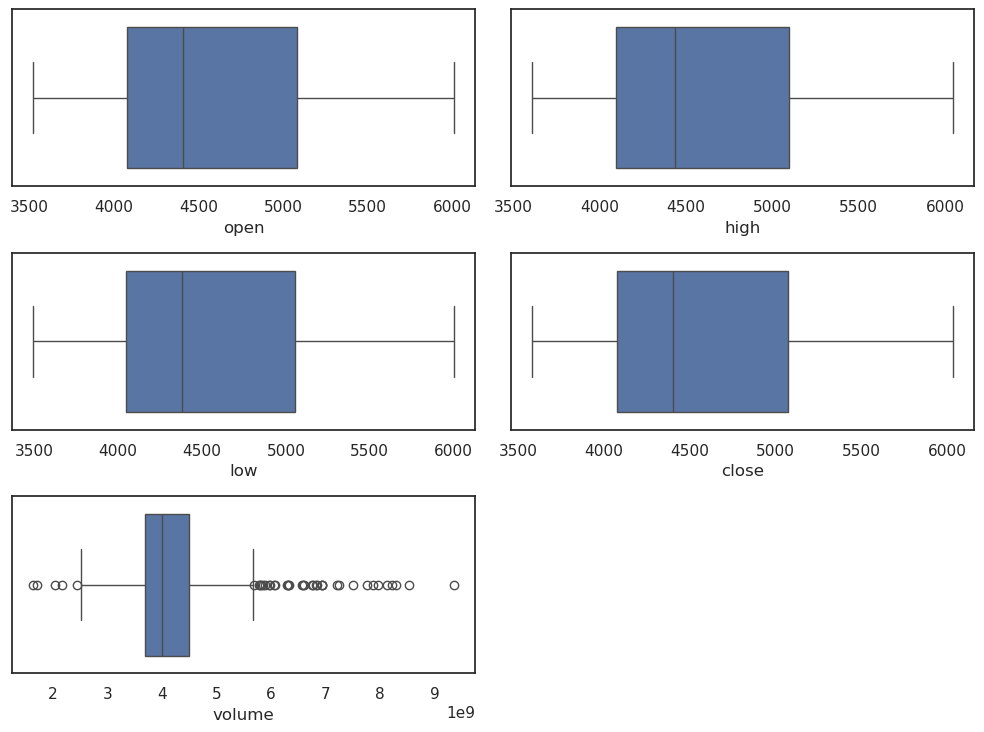

In [15]:
# Boxplot
fig = plt.figure(figsize=(10,7))

for i in range(5): #for 6 columns
    fig.tight_layout()
    grid_col = "32{}".format(i+1)
    ax = fig.add_subplot(int(grid_col))
    sns.boxplot(data=smp500, x=col_names[i], ax=ax)
    
plt.show()

# Q2

In [17]:
compareResults = pd.DataFrame() #save every result metric for comparison
firstPredictionRange = smp500[(smp500.index >= '2022-02-01')&(smp500.index < '2023-01-01')]
first_year = smp500.drop(columns = ['volume'])[(smp500.index >= '2022-01')&(smp500.index < '2023-01')]

firstEleven = first_year[(first_year.index >= '2022-02')]
resultsComparison = pd.DataFrame()
firstPredictionLength = len(firstPredictionRange)
future_dates = pd.date_range(start='2022-02-01', periods=firstPredictionLength, freq='B')  # Business days
# data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']

In [18]:
def calculateRMSE(prediction, realData, axis= 0):
    return np.sqrt(((realData - prediction)**2).sum(axis=axis)/len(realData))

In [19]:
def calculateMAD(prediction, realData, axis= 0):
    return np.abs((realData - prediction)).sum(axis=axis)/len(realData)

In [20]:
def calculateTrackingSignal(prediction, realData, MAD):
    forecast_errors = (realData - prediction)
    algebraic_sum_errors = forecast_errors.sum(axis=0)
    tracking_signal = algebraic_sum_errors / MAD
    return tracking_signal

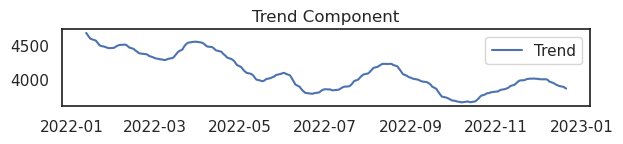

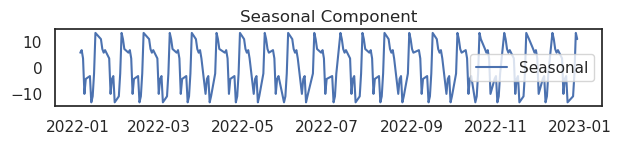

In [21]:
df_dec = seasonal_decompose(first_year['close'].to_timestamp(), model='additive', period=12)

plt.subplot(4, 1, 2)
plt.plot(df_dec.trend, label='Trend')
plt.legend()
plt.title('Trend Component')
plt.tight_layout()
plt.show()


plt.subplot(4,1,3)
plt.plot(df_dec.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')
plt.tight_layout()
plt.show()

### Naive Aproach

In [23]:
# group by month
monthly_summary = smp500.drop(columns = ['volume'])
naivePrediction = first_year[(first_year.index == '2022-01-31')].iloc[0]
firstMonth = first_year[(first_year.index >= '2022-01') & (first_year.index < '2022-02')]

# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([naivePrediction] * len(firstEleven), columns=firstEleven.columns, index=firstEleven.index)
resultsComparison['naive']= repeated_naiveResult['close']
naiveMAD = calculateMAD(repeated_naiveResult, firstEleven) 

print(calculateRMSE(repeated_naiveResult, firstEleven), end="\n\n")
print(naiveMAD, end="\n\n")
print(calculateTrackingSignal(repeated_naiveResult, firstEleven, naiveMAD))

open     456.440039
high     497.767795
low      472.924517
close    528.086996
dtype: float64

open     394.265498
high     432.201991
low      410.237532
close    463.375671
dtype: float64

open    -218.612865
high    -226.688451
low     -221.583309
close   -228.413287
dtype: float64


### Rolling window

In [25]:
#We compute a fast moving average of 5 days (MA40) and a slow moving average of 20 days on the close price.
data = firstMonth.copy()

MAS = 20
# MAF = 20 #20 should be the maximum because we have 20 days with data
data['rolling_close_mean'] = data['close'].rolling(window=MAS).mean()
# data['rolling_close_mean_fast'] = data['close'].rolling(window=MAF).mean()

predicted_values = []
last_window = data['close'].iloc[-MAS:].tolist()
# predicted_values_fast = []
# last_window_fast = data['close'].iloc[-MAF:].tolist()

for _ in range(firstPredictionLength):
    # Calculate the mean of the current window
    next_prediction = sum(last_window) / MAS
    predicted_values.append(next_prediction)
    last_window.pop(0)
    last_window.append(next_prediction)
    # next_prediction_fast = sum(last_window_fast) / MAF
    # predicted_values_fast.append(next_prediction_fast)
    
    # last_window_fast.pop(0)
    # last_window_fast.append(next_prediction_fast)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values}).set_index('date')
# predictions_fast = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values_fast}).set_index('date')
resultsComparison['rolling'] = predictions['close']
# resultsComparison['roling_fast'] = predictions_fast['close']

rollingMAD = calculateMAD(predictions['close'], firstEleven['close']) 
print(calculateRMSE(predictions['close'], firstEleven['close']), end="\n")
print(rollingMAD, end= "\n")

print(calculateTrackingSignal(predictions['close'], firstEleven['close'], rollingMAD))

500.6715293466751
428.6410910200197
-227.90116160345173


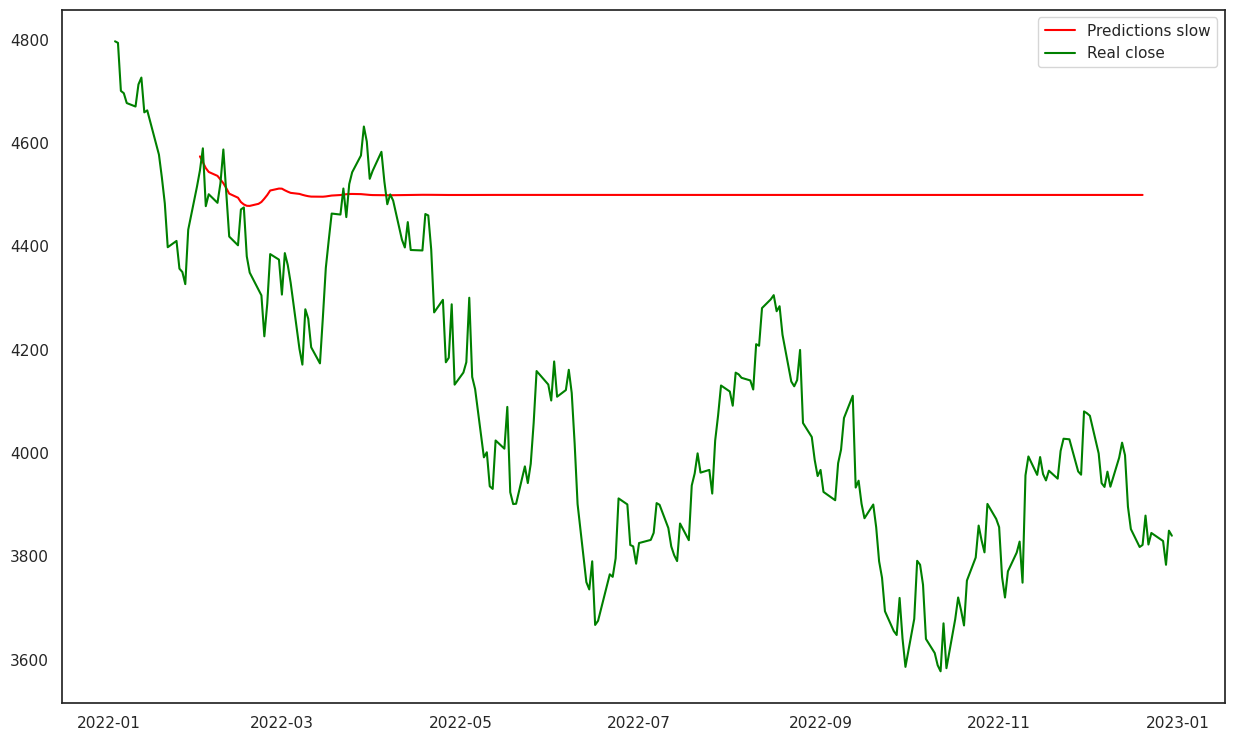

In [26]:
plt.figure(figsize= (15,9))

plt.plot(predictions.index.to_timestamp(), predictions['close'], label='Predictions slow', color='red')
plt.plot(first_year.index.to_timestamp(), first_year['close'], label='Real close', color='green')
plt.legend()
plt.show()

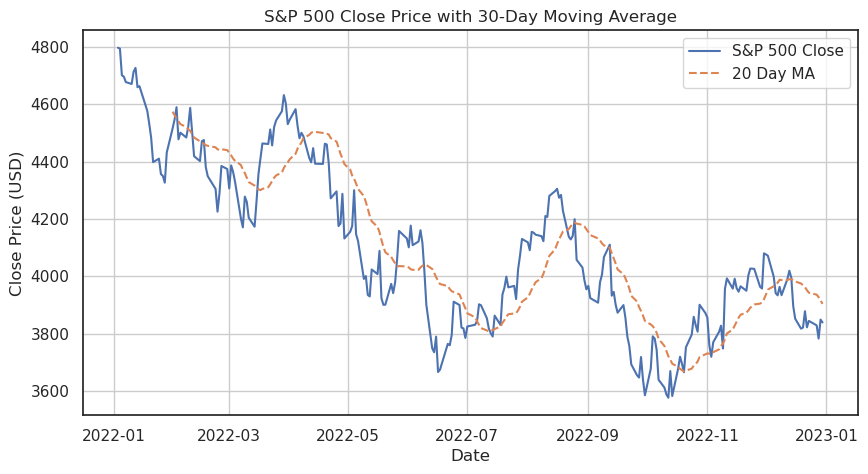

In [27]:
#Source: https://medium.com/@wl8380/how-to-create-a-stock-chart-in-python-a-step-by-step-guide-with-aapl-6d6dd2eceb67
#Calculate the 30-Day Moving Average
df['20_MA']= first_year['close'].rolling(window=20).mean()

#Plot
plt.figure(figsize=(10,5))
plt.plot(first_year['close'].to_timestamp(), label = 'S&P 500 Close')
plt.plot(df['20_MA'], label = '20 Day MA', linestyle= '--')
plt.title('S&P 500 Close Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [30]:
# Apply Simple Exponential Smoothing
alpha = 0.90
ses_model = SimpleExpSmoothing(data['close']).fit(smoothing_level=alpha, optimized=False)
sesModelAllYear = SimpleExpSmoothing(first_year['close']).fit(smoothing_level=alpha, optimized=False)

# Forecast for the next 10 periods
forecast = ses_model.forecast(firstPredictionLength)
predictionsSES = pd.DataFrame({'date': future_dates.to_period('D'), 'close': forecast}).set_index('date')
resultsComparison['SES'] = predictionsSES['close']

SESMAD = calculateMAD(predictionsSES['close'], firstEleven['close'])
print(calculateRMSE(predictionsSES['close'], firstEleven['close']))
print(SESMAD, end="\n")
print(calculateTrackingSignal(predictionsSES['close'], firstEleven['close'], SESMAD))

506.646458316341
434.7523216704819
-227.65578268465478


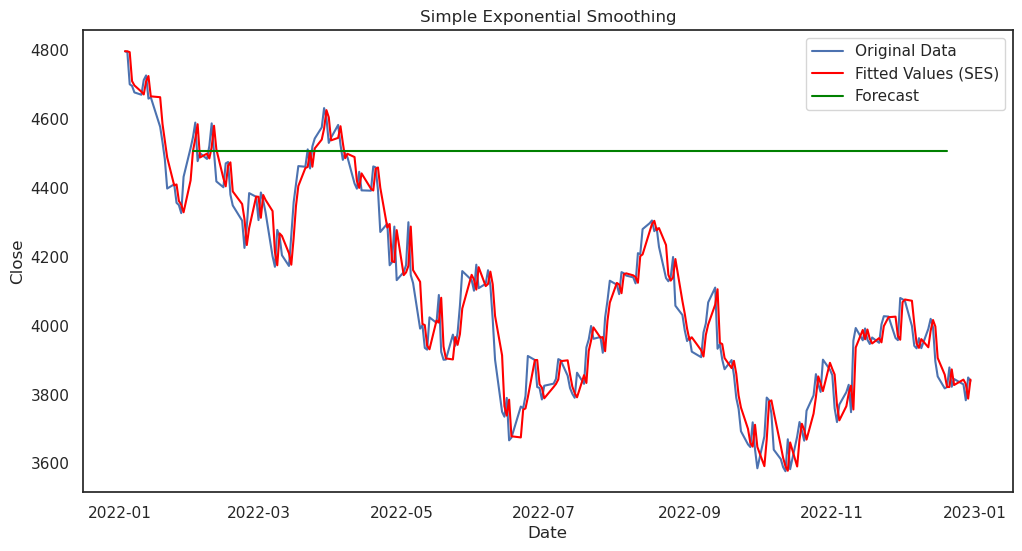

In [31]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(first_year.index.to_timestamp(), first_year['close'], label='Original Data')
plt.plot(sesModelAllYear.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(predictionsSES, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

### Double Exponential Smoothing

216.24226249410737
169.1915623650106
172.5287149090517


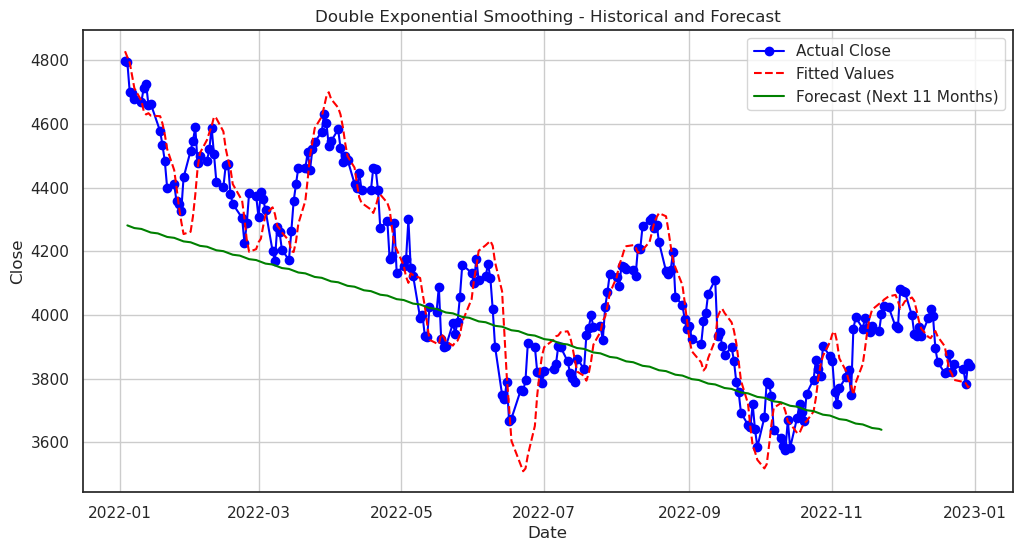

In [33]:
# Fit Double Exponential Smoothing Model
model = sm.tsa.ExponentialSmoothing(data['close'], trend='add')
des_model = model.fit(smoothing_level=0.2, smoothing_slope=0.5)

modelYear = sm.tsa.ExponentialSmoothing(first_year['close'], trend='add')
des_modelYear = modelYear.fit(smoothing_level=0.2, smoothing_slope=0.5)

# Forecast the next 11 months
future_index = pd.date_range(start=data.index[0].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='B').to_period('D')

# Ensure forecast has the same length as future_index
forecast = des_model.forecast(firstPredictionLength)
DES_df = pd.DataFrame({'close': forecast.values}, index=future_index)
resultsComparison['DES'] = DES_df['close']

DESMAD = calculateMAD(DES_df['close'], firstEleven['close'])
print(calculateRMSE(DES_df['close'], firstEleven['close']))
print(DESMAD)
print(calculateTrackingSignal(DES_df['close'], firstEleven['close'], DESMAD))

# Plot Historical and Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(first_year.index.to_timestamp(), first_year['close'], label='Actual Close', marker='o', color='blue')
plt.plot(des_modelYear.fittedvalues.index, des_modelYear.fittedvalues, label='Fitted Values', color='red', linestyle='--')
plt.plot(DES_df.index, DES_df['close'], label='Forecast (Next 11 Months)', color='green')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Double Exponential Smoothing - Historical and Forecast')
plt.legend()
plt.grid()
plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [35]:
data = data.copy()
train = firstMonth
test = firstEleven

def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index, y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [36]:
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['close']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

In [37]:
# Fit Holt's model
model_holt = Holt(train['close'], damped_trend=True, initialization_method='estimated').fit(optimized=True)
forecasts_holt = model_holt.forecast(firstPredictionLength)

In [38]:
# Fit Holt-Winters model
model_holt_winters = ExponentialSmoothing(
    train['close'], trend='mul', seasonal='mul', seasonal_periods=10, initialization_method='estimated'
).fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(firstPredictionLength)

forecast_index = pd.date_range(start=train.index[-1].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='B').to_period('D')
HOLT_df = pd.DataFrame({
    'Holt Forecast': forecasts_holt.values,
    'Holt-Winters Forecast': forecasts_holt_winters.values
}, index=forecast_index)

resultsComparison['Holt'] = HOLT_df['Holt Forecast']
resultsComparison['Holt-winter'] = HOLT_df['Holt-Winters Forecast']

In [39]:
print(model_holt_winters.summary())

holtMAD = calculateMAD(HOLT_df['Holt Forecast'], firstEleven['close'])
holtWinterMAD = calculateMAD(HOLT_df['Holt-Winters Forecast'], firstEleven['close'])

print("Holt Forecast: ")
print(calculateRMSE(HOLT_df['Holt Forecast'], firstEleven['close']))
print(holtMAD)
print(calculateTrackingSignal(HOLT_df['Holt Forecast'], firstEleven['close'], holtMAD), end= "\n\n")

print("Holt-Winters Forecast:")
print(calculateRMSE(HOLT_df['Holt Forecast'], firstEleven['close']))
print(holtWinterMAD)
print(calculateTrackingSignal(HOLT_df['Holt-Winters Forecast'], firstEleven['close'], holtWinterMAD))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                   20
Model:             ExponentialSmoothing   SSE                          30394.189
Optimized:                         True   AIC                            174.525
Trend:                   Multiplicative   BIC                            188.466
Seasonal:                Multiplicative   AICC                           355.859
Seasonal Periods:                    10   Date:                 Tue, 10 Dec 2024
Box-Cox:                          False   Time:                         23:08:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9949999                alpha                 True
smoothing_trend          

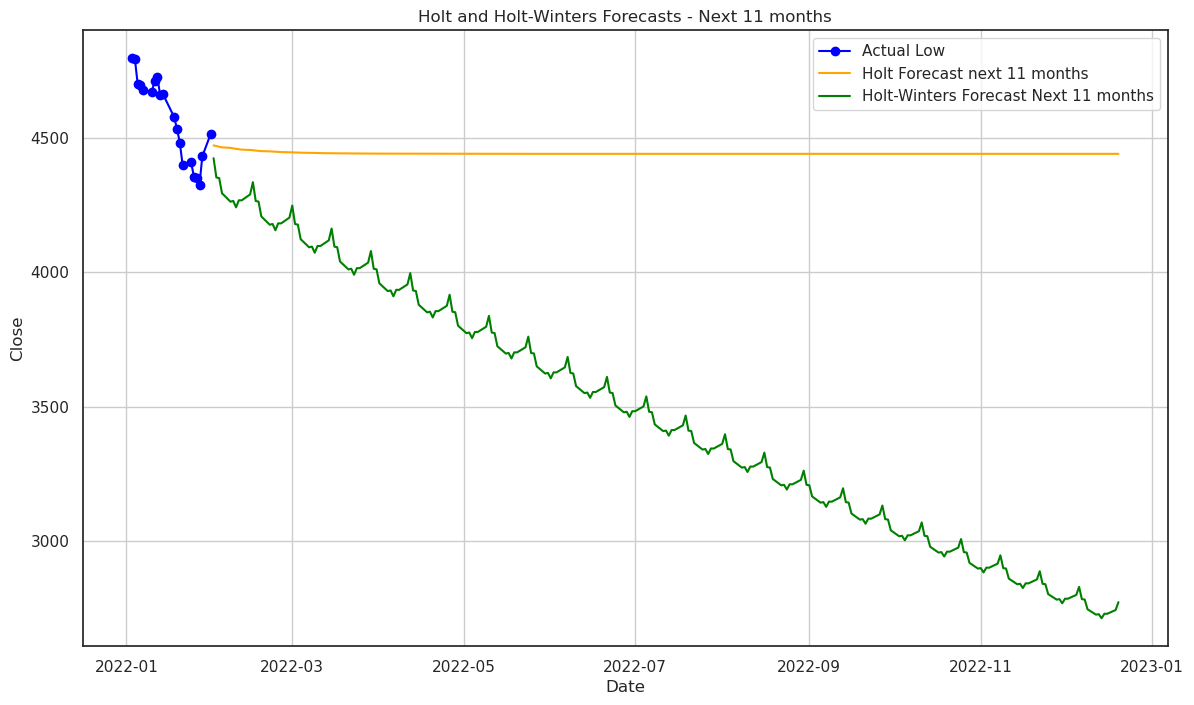

In [40]:
plt.figure(figsize=(14, 8))
plt.plot(train.index.to_timestamp(), train['close'], label='Actual Low', color='blue', marker='o')
plt.plot(HOLT_df.index.to_timestamp(), HOLT_df['Holt Forecast'], label='Holt Forecast next 11 months', color='orange')
plt.plot(HOLT_df.index.to_timestamp(), HOLT_df['Holt-Winters Forecast'], label='Holt-Winters Forecast Next 11 months', color='green')

plt.title('Holt and Holt-Winters Forecasts - Next 11 months')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid()
plt.show()

# Q3 

In [42]:
resultsComparison.to_csv('everyResult.csv')

In [43]:
secondPredictionRange = smp500[(smp500.index >= '2023-02-01')&(smp500.index < '2024-01-01')]
second_year = smp500.drop(columns = ['volume'])[(smp500.index >= '2023-01')&(smp500.index < '2024-01')]

secondEleven = second_year[(second_year.index >= '2023-02')]
resultsComparisonSecond = pd.DataFrame()
secondPredictionLength = len(secondPredictionRange)
future_dates = pd.date_range(start='2023-02-01', periods=secondPredictionLength, freq='B')  # Business days
# data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']

### Naive Aproach

In [45]:
# group by month
monthly_summary = smp500.drop(columns = ['volume'])
naivePrediction = second_year[(second_year.index == '2023-01-31')].iloc[0]
firstMonthSecond = second_year[(second_year.index >= '2023-01') & (second_year.index < '2023-02')]

# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([naivePrediction] * len(secondEleven), columns=secondEleven.columns, index=secondEleven.index)
resultsComparisonSecond['naive']= repeated_naiveResult['close']
naiveMAD = calculateMAD(repeated_naiveResult, secondEleven) 
print(calculateRMSE(repeated_naiveResult, secondEleven), end="\n\n")
print(naiveMAD, end="\n\n")
print(calculateTrackingSignal(repeated_naiveResult, secondEleven, naiveMAD))

open     360.625555
high     332.012419
low      347.381346
close    319.903738
dtype: float64

open     302.282087
high     274.081261
low      288.564391
close    262.136391
dtype: float64

open     219.782656
high     213.498762
low      214.218704
close    206.385804
dtype: float64


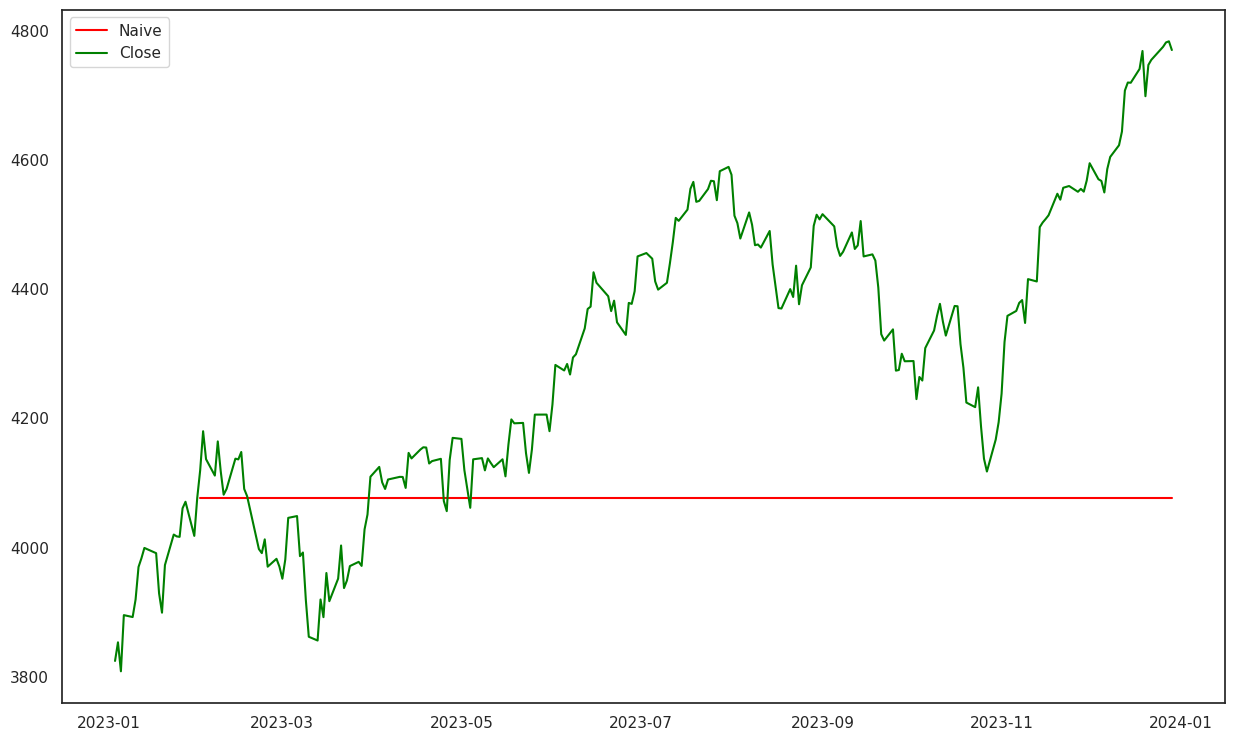

In [46]:
plt.figure(figsize= (15,9))

plt.plot(repeated_naiveResult.index.to_timestamp(), repeated_naiveResult['close'], label='Naive', color= 'red')
plt.plot(second_year.index.to_timestamp(), second_year['close'], label='Close', color='green')
plt.legend()
plt.show()

### Get best window size

In [48]:
data = firstMonthSecond.copy()
results = pd.DataFrame()
genericResults = pd.DataFrame(columns = ['calculateRMSE', 'rollingMAD', 'calculateTrackingSignal'])

for i in range(5, 20):
    MAS = i
    data['rolling_close_mean'] = data['close'].rolling(window=MAS).mean()
    
    predicted_values = []
    last_window = data['close'].iloc[-MAS:].tolist()
    
    for _ in range(secondPredictionLength):
        # Calculate the mean of the current window
        next_prediction = sum(last_window) / MAS
        predicted_values.append(next_prediction)
        last_window.pop(0)
        last_window.append(next_prediction)

    predictions = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values}).set_index('date')
    rollingMAD = calculateMAD(predictions['close'], secondEleven['close']) 
    
    results = pd.DataFrame(columns = ['calculateRMSE', 'rollingMAD', 'calculateTrackingSignal'])
    genericResults.loc[i] = [calculateRMSE(predictions['close'], secondEleven['close']), rollingMAD, calculateTrackingSignal(predictions['close'], secondEleven['close'], rollingMAD)]

print('best window size is: \n',genericResults.idxmin())
# print(genericResults)

best window size is: 
 calculateRMSE              5
rollingMAD                 5
calculateTrackingSignal    5
dtype: int64


### Rolling window

In [50]:
#We compute a fast moving average of 5 days (MA40) and a slow moving average of 20 days on the close price.
data = firstMonthSecond.copy()

MA = 5
data['rolling_close_mean'] = data['close'].rolling(window=MA).mean()
# data['rolling_close_mean_fast'] = data['close'].rolling(window=MAF).mean()

predicted_values = []
last_window = data['close'].iloc[-MA:].tolist()
# predicted_values_fast = []
# last_window_fast = data['close'].iloc[-MAF:].tolist()

for _ in range(secondPredictionLength):
    # Calculate the mean of the current window
    next_prediction = sum(last_window) / MA
    predicted_values.append(next_prediction)
    last_window.pop(0)
    last_window.append(next_prediction)
    # next_prediction_fast = sum(last_window_fast) / MAF
    # predicted_values_fast.append(next_prediction_fast)
    
    # last_window_fast.pop(0)
    # last_window_fast.append(next_prediction_fast)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values}).set_index('date')
# predictions_fast = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values_fast}).set_index('date')
resultsComparisonSecond['roling'] = predictions['close']
# resultsComparisonSecond['roling_fast'] = predictions_fast['close']

rollingMAD = calculateMAD(predictions['close'], secondEleven['close']) 
print(calculateRMSE(predictions['close'], secondEleven['close']), end="\n")
print(rollingMAD, end= "\n")

print(calculateTrackingSignal(predictions['close'], secondEleven['close'], rollingMAD))

313.97631563562845
257.8057356585499
211.3195415839347


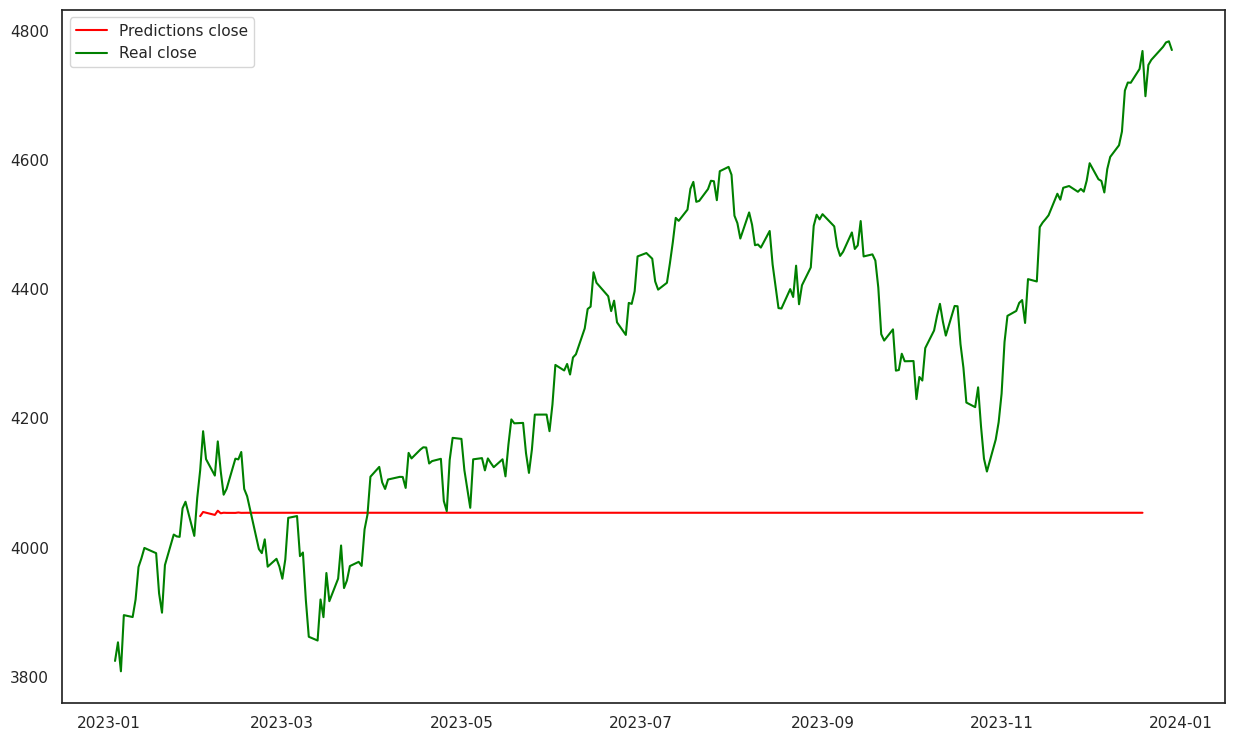

In [51]:
plt.figure(figsize= (15,9))

plt.plot(predictions.index.to_timestamp(), predictions['close'], label='Predictions close', color='red')
plt.plot(second_year.index.to_timestamp(), second_year['close'], label='Real close', color='green')
plt.legend()
plt.show()

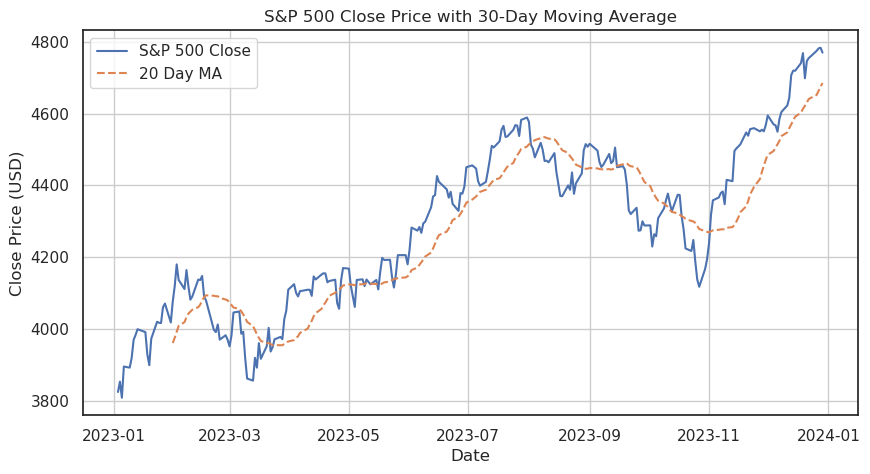

In [52]:
#Source: https://medium.com/@wl8380/how-to-create-a-stock-chart-in-python-a-step-by-step-guide-with-aapl-6d6dd2eceb67
#Calculate the 30-Day Moving Average
df['20_MA']= second_year['close'].rolling(window=20).mean()

#Plot
plt.figure(figsize=(10,5))
plt.plot(second_year['close'].to_timestamp(), label = 'S&P 500 Close')
plt.plot(df['20_MA'], label = '20 Day MA', linestyle= '--')
plt.title('S&P 500 Close Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [55]:
genericResultsSES = pd.DataFrame(columns = ['calculateRMSE', 'rollingMAD', 'calculateTrackingSignal'])

for alpha in np.arange(0.01, 1.0, 0.01):
    ses_model = SimpleExpSmoothing(data['close']).fit(smoothing_level=alpha, optimized=False)
    sesModelAllYear = SimpleExpSmoothing(second_year['close']).fit(smoothing_level=alpha, optimized=False)
    forecast = ses_model.forecast(secondPredictionLength)
    predictionsSES = pd.DataFrame({'date': future_dates.to_period('D'), 'close': forecast}).set_index('date')
    resultsComparison['SES'] = predictionsSES['close']
    SESMAD = calculateMAD(predictionsSES['close'], secondEleven['close'])
    results = pd.DataFrame(columns = ['calculateRMSE', 'rollingMAD', 'calculateTrackingSignal'])
    genericResultsSES.loc[alpha] = [calculateRMSE(predictionsSES['close'], secondEleven['close']), SESMAD, calculateTrackingSignal(predictionsSES['close'], secondEleven['close'], SESMAD)]

print(genericResultsSES.min()) 

print(genericResultsSES.idxmin()) 

calculateRMSE              297.347371
rollingMAD                 241.792166
calculateTrackingSignal    204.548422
dtype: float64
calculateRMSE              0.99
rollingMAD                 0.99
calculateTrackingSignal    0.99
dtype: float64


In [56]:
# Apply Simple Exponential Smoothing
alpha = 0.99
ses_model = SimpleExpSmoothing(data['close']).fit(smoothing_level=alpha, optimized=False)
sesModelAllYear = SimpleExpSmoothing(second_year['close']).fit(smoothing_level=alpha, optimized=False)

# Forecast for the next 10 periods
forecast = ses_model.forecast(secondPredictionLength)
predictionsSES = pd.DataFrame({'date': future_dates.to_period('D'), 'close': forecast}).set_index('date')
resultsComparison['SES'] = predictionsSES['close']

SESMAD = calculateMAD(predictionsSES['close'], secondEleven['close'])
print(calculateRMSE(predictionsSES['close'], secondEleven['close']))
print(SESMAD, end="\n")
print(calculateTrackingSignal(predictionsSES['close'], secondEleven['close'], SESMAD))

297.34737095129026
241.79216557867812
204.54842249414406


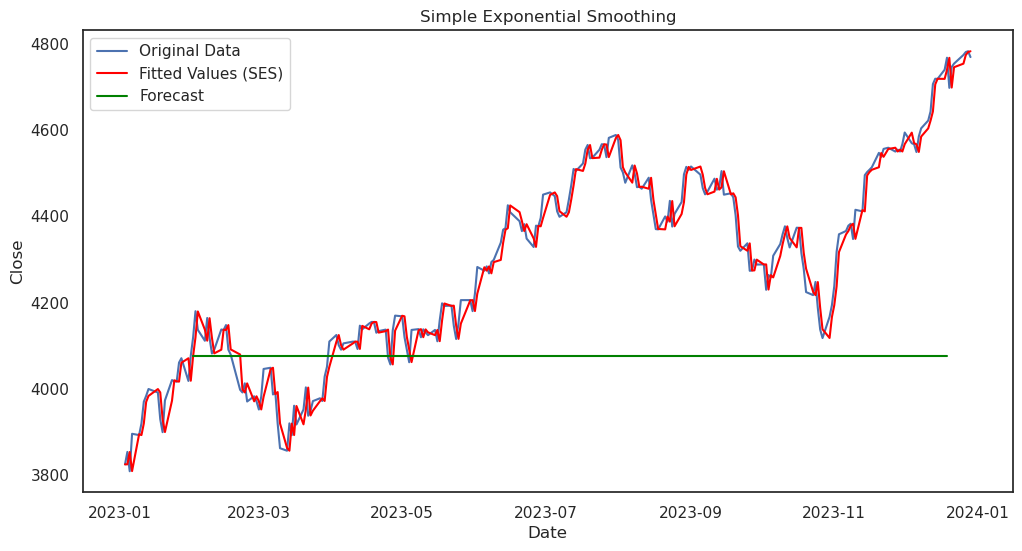

In [57]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(second_year.index.to_timestamp(), second_year['close'], label='Original Data')
plt.plot(sesModelAllYear.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(predictionsSES, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

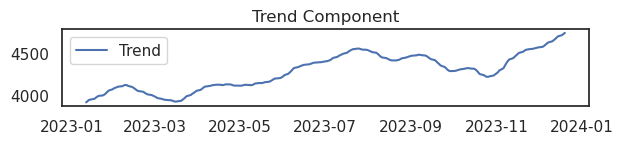

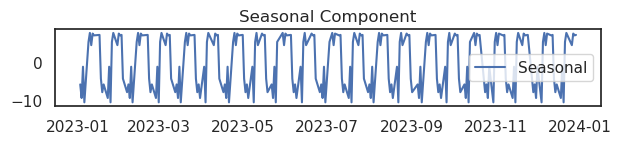

In [58]:
df_dec = seasonal_decompose(second_year['close'].to_timestamp(), model='additive', period=12)

plt.subplot(4, 1, 2)
plt.plot(df_dec.trend, label='Trend')
plt.legend()
plt.title('Trend Component')
plt.tight_layout()
plt.show()


plt.subplot(4,1,3)
plt.plot(df_dec.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')
plt.tight_layout()
plt.show()

### Optimization double exponential smoothing

In [60]:
lowestMAD = 99999999999999999999

model = sm.tsa.ExponentialSmoothing(data['close'], trend='add')
future_index = pd.date_range(start=data.index[0].to_timestamp() + pd.Timedelta(days=1), periods=secondPredictionLength, freq='B').to_period('D')
# for SL in np.arange(0.01, 1.0, 0.01): 
#     for SS in np.arange(0.01, 1.0, 0.01): 
#         des_model = model.fit(smoothing_level= SS, smoothing_slope= SL)
#         forecast = des_model.forecast(secondPredictionLength)
#         DES_df = pd.DataFrame({'close': forecast.values}, index=future_index)
#         DESMAD = calculateMAD(DES_df['close'], secondEleven['close'])
#         trackingSignal = calculateTrackingSignal(DES_df['close'], secondEleven['close'], DESMAD)
#         # print(DES_df['close'].mean())
#         if (DESMAD < lowestMAD):
#             lowestMAD= DESMAD
#             print('Best SS: %s, SL: %s and DESMAD : %s' %(SS, SL, DESMAD))
            

### Double Exponential Smoothing

127.57373957421889
101.46934810622285
-2.5962380261754965


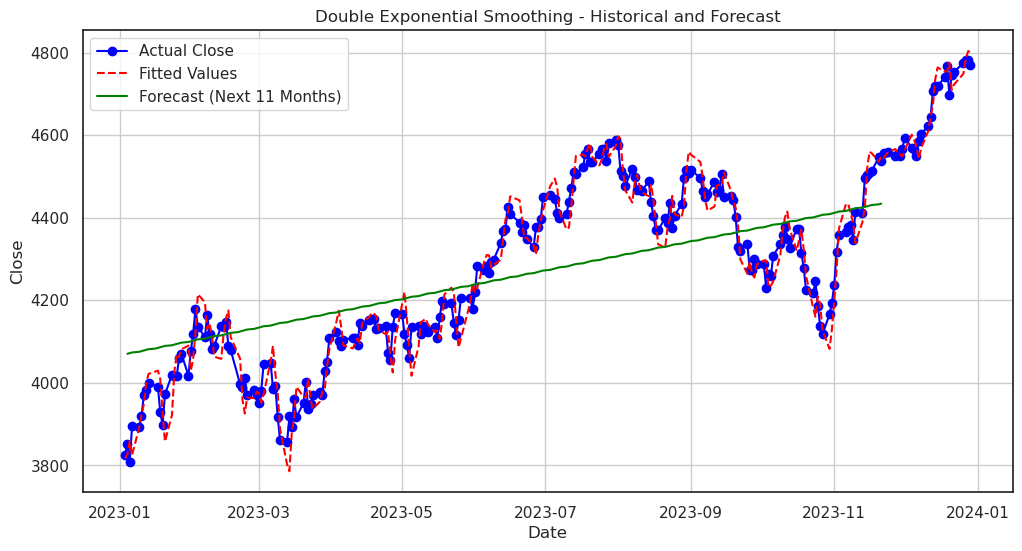

In [132]:
# Fit Double Exponential Smoothing Model
des_model = model.fit(smoothing_level=0.53, smoothing_slope=0.95)

modelYear = sm.tsa.ExponentialSmoothing(second_year['close'], trend='add')
des_modelYear = modelYear.fit(smoothing_level=0.53, smoothing_slope=0.95)

# Forecast the next 11 months
future_index = pd.date_range(start=data.index[0].to_timestamp() + pd.Timedelta(days=1), periods=secondPredictionLength, freq='B').to_period('D')

# Ensure forecast has the same length as future_index
forecast = des_model.forecast(secondPredictionLength)
DES_df = pd.DataFrame({'close': forecast.values}, index=future_index)
resultsComparison['DES'] = DES_df['close']

DESMAD = calculateMAD(DES_df['close'], secondEleven['close'])
print(calculateRMSE(DES_df['close'], secondEleven['close']))
print(DESMAD)
print(calculateTrackingSignal(DES_df['close'], secondEleven['close'], DESMAD))

# Plot Historical and Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(second_year.index.to_timestamp(), second_year['close'], label='Actual Close', marker='o', color='blue')
plt.plot(des_modelYear.fittedvalues.index, des_modelYear.fittedvalues, label='Fitted Values', color='red', linestyle='--')
plt.plot(DES_df.index, DES_df['close'], label='Forecast (Next 11 Months)', color='green')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Double Exponential Smoothing - Historical and Forecast')
plt.legend()
plt.grid()
plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [64]:
data = data.copy()
train = firstMonthSecond
test = secondEleven

def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index, y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [65]:
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['close']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

In [66]:
# Fit Holt's model
model_holt = Holt(train['close'], damped_trend=True, initialization_method='estimated').fit(optimized=True)
forecasts_holt = model_holt.forecast(secondPredictionLength)

In [67]:
# Fit Holt-Winters model
model_holt_winters = ExponentialSmoothing(
    train['close'], trend='mul', seasonal='mul', seasonal_periods=10, initialization_method='estimated'
).fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(secondPredictionLength)

forecast_index = pd.date_range(start=train.index[-1].to_timestamp() + pd.Timedelta(days=1), periods=secondPredictionLength, freq='B').to_period('D')
HOLT_df = pd.DataFrame({
    'Holt Forecast': forecasts_holt.values,
    'Holt-Winters Forecast': forecasts_holt_winters.values
}, index=forecast_index)

resultsComparisonSecond['Holt'] = HOLT_df['Holt Forecast']
resultsComparisonSecond['Holt-winter'] = HOLT_df['Holt-Winters Forecast']

In [68]:
print(model_holt_winters.summary())

holtMAD = calculateMAD(HOLT_df['Holt Forecast'], secondEleven['close'])
holtWinterMAD = calculateMAD(HOLT_df['Holt-Winters Forecast'], secondEleven['close'])

print("Holt Forecast: ")
print(calculateRMSE(HOLT_df['Holt Forecast'], secondEleven['close']))
print(holtMAD)
print(calculateTrackingSignal(HOLT_df['Holt Forecast'], secondEleven['close'], holtMAD), end= "\n\n")

print("Holt-Winters Forecast:")
print(calculateRMSE(HOLT_df['Holt Forecast'], secondEleven['close']))
print(holtWinterMAD)
print(calculateTrackingSignal(HOLT_df['Holt-Winters Forecast'], secondEleven['close'], holtWinterMAD))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                   20
Model:             ExponentialSmoothing   SSE                          15826.045
Optimized:                         True   AIC                            161.474
Trend:                   Multiplicative   BIC                            175.414
Seasonal:                Multiplicative   AICC                           342.807
Seasonal Periods:                    10   Date:                 Tue, 10 Dec 2024
Box-Cox:                          False   Time:                         23:08:26
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3939286                alpha                 True
smoothing_trend          

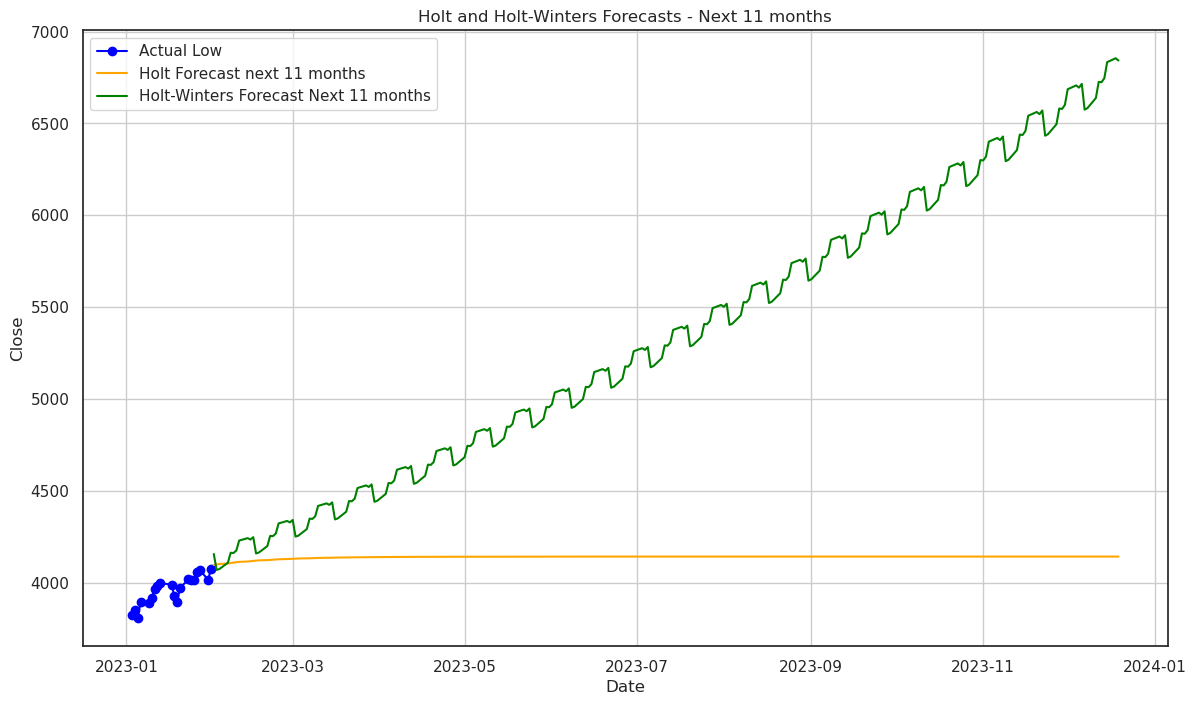

In [69]:
plt.figure(figsize=(14, 8))
plt.plot(train.index.to_timestamp(), train['close'], label='Actual Low', color='blue', marker='o')
plt.plot(HOLT_df.index.to_timestamp(), HOLT_df['Holt Forecast'], label='Holt Forecast next 11 months', color='orange')
plt.plot(HOLT_df.index.to_timestamp(), HOLT_df['Holt-Winters Forecast'], label='Holt-Winters Forecast Next 11 months', color='green')

plt.title('Holt and Holt-Winters Forecasts - Next 11 months')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid()
plt.show()

### D Comparison of datasets

In [71]:
# print(resultsComparisonSecond)
# print(resultsComparison)

# ensure that there are only comon columns
commonColumns = resultsComparison.columns.intersection(resultsComparisonSecond.columns)
firstYearAligned = resultsComparison[commonColumns]
secondYearAligned = resultsComparisonSecond[commonColumns]

firstYearStats = secondYearAligned.describe()
secondYearStats = firstYearAligned.describe()
statsDifference = np.abs(secondYearStats - firstYearStats)
print("Difference in Descriptive Statistics:")
print(statsDifference.round(2))

Difference in Descriptive Statistics:
        close   naive    Holt  Holt-winter
count    1.00    1.00    1.00         1.00
mean   254.46  438.95  301.95      1884.85
std     45.85    0.00    3.10       306.10
min    278.73  438.95  343.26      1358.13
25%    285.34  438.95  298.20      1593.11
50%    333.88  438.95  297.25      1879.50
75%    217.99  438.95  297.43      2164.24
max    151.75  438.95  328.55      2430.07


### E. Monthly Data Set Analysis

In [73]:
# read the csvs
cac_40 = pd.read_csv(projectPath + '/CAC 40.csv')
dax = pd.read_csv(projectPath + '/DAX.csv')
ftse100_ukx = pd.read_csv(projectPath + '/FTSE100 (UKX) .csv')
nasdaq_composite_ixic = pd.read_csv(projectPath + '/NASDAQ Composite (IXIC).csv')
nikkei_225_n225 = pd.read_csv(projectPath + '/Nikkei 225 (N225).csv')
russell_2000_rut = pd.read_csv(projectPath + '/Russell 2000 (RUT).csv')
smi_ssmi = pd.read_csv(projectPath + '/SMI (SSMI).csv')
smp5001 = pd.read_csv(projectPath + '/smp5001.csv')
s_p_tsx60_sptse = pd.read_csv(projectPath + '/S&P_TSX60 (SPTSE).csv')
stoxx_50_eur_stoxx50er = pd.read_csv(projectPath + '/STOXX 50 EUR (STOXX50ER).csv')

In [74]:
cac_40 = cac_40[['Date', 'Close']]
cac_40['Date'] = pd.to_datetime(cac_40['Date'], dayfirst=True)
cac_40 = cac_40.set_index(cac_40['Date']).sort_index().to_period('D').drop(columns='Date')

dax = dax[['Date', 'Close']]
dax['Date'] = pd.to_datetime(dax['Date'], dayfirst=True)
dax = dax.set_index(dax['Date']).sort_index().to_period('D').drop(columns='Date')

ftse100_ukx = ftse100_ukx[['Date', 'Close']]
ftse100_ukx['Date'] = pd.to_datetime(ftse100_ukx['Date'], dayfirst=True)
ftse100_ukx = ftse100_ukx.set_index(ftse100_ukx['Date']).sort_index().to_period('D').drop(columns='Date')

nasdaq_composite_ixic = nasdaq_composite_ixic[['Date', 'Close']]
nasdaq_composite_ixic['Date'] = pd.to_datetime(nasdaq_composite_ixic['Date'])
nasdaq_composite_ixic = nasdaq_composite_ixic.set_index(nasdaq_composite_ixic['Date']).sort_index().to_period('D').drop(columns='Date')

nikkei_225_n225 = nikkei_225_n225[['Date', 'Close']]
nikkei_225_n225['Date'] = pd.to_datetime(nikkei_225_n225['Date'], dayfirst=True)
nikkei_225_n225 = nikkei_225_n225.set_index(nikkei_225_n225['Date']).sort_index().to_period('D').drop(columns='Date')

russell_2000_rut = russell_2000_rut[['Date', 'Close']]
russell_2000_rut['Date'] = pd.to_datetime(russell_2000_rut['Date'], dayfirst=True)
russell_2000_rut = russell_2000_rut.set_index(russell_2000_rut['Date']).sort_index().to_period('D').drop(columns='Date')

smi_ssmi = smi_ssmi[['Date', 'Close']]
smi_ssmi['Date'] = pd.to_datetime(smi_ssmi['Date'], dayfirst=True)
smi_ssmi = smi_ssmi.set_index(smi_ssmi['Date']).sort_index().to_period('D').drop(columns='Date')

smp5001 = smp5001[['Date', 'Close']]
smp5001['Date'] = pd.to_datetime(smp5001['Date'], dayfirst=True)
smp5001 = smp5001.set_index(smp5001['Date']).sort_index().to_period('D').drop(columns='Date')

s_p_tsx60_sptse = s_p_tsx60_sptse[['Date', 'Close']]
s_p_tsx60_sptse['Date'] = pd.to_datetime(s_p_tsx60_sptse['Date'], dayfirst=True)
s_p_tsx60_sptse = s_p_tsx60_sptse.set_index(s_p_tsx60_sptse['Date']).sort_index().to_period('D').drop(columns='Date')

stoxx_50_eur_stoxx50er = stoxx_50_eur_stoxx50er[['Date', 'Close']]
stoxx_50_eur_stoxx50er['Date'] = pd.to_datetime(stoxx_50_eur_stoxx50er['Date'], dayfirst=True)
stoxx_50_eur_stoxx50er = stoxx_50_eur_stoxx50er.set_index(stoxx_50_eur_stoxx50er['Date']).sort_index().to_period('D').drop(columns='Date')


In [75]:
def first_business_day_each_month(df):
    df.index = df.index.to_timestamp()
    # use only dates in 2022
    df_2022 = df.loc['2022']
    # B.M.S. : Business Month Start
    return df_2022.resample('BMS').first()  

In [76]:
cac_40_first_days = first_business_day_each_month(cac_40)
dax_first_days = first_business_day_each_month(dax)
ftse100_ukx_first_days = first_business_day_each_month(ftse100_ukx)
nasdaq_composite_ixic_first_days = first_business_day_each_month(nasdaq_composite_ixic)
nikkei_225_n225_first_days = first_business_day_each_month(nikkei_225_n225)
russell_2000_rut_first_days = first_business_day_each_month(russell_2000_rut)
smi_ssmi_first_days = first_business_day_each_month(smi_ssmi)
smp5001_first_days = first_business_day_each_month(smp5001)
s_p_tsx60_sptse_first_days = first_business_day_each_month(s_p_tsx60_sptse)
stoxx_50_eur_stoxx50er_first_days = first_business_day_each_month(stoxx_50_eur_stoxx50er)
smp500_first_days = first_business_day_each_month(smp500)

In [77]:
# Combine into a single dataframe
combined_df = pd.concat(
    [
        cac_40_first_days['Close'].rename('cac_40'),
        dax_first_days['Close'].rename('dax'),
        ftse100_ukx_first_days['Close'].rename('ftse100_ukx'),
        nasdaq_composite_ixic_first_days['Close'].rename('nasdaq_composite_ixic'),
        nikkei_225_n225_first_days['Close'].rename('nikkei_225_n225'),
        russell_2000_rut_first_days['Close'].rename('russell_2000_rut'),
        smi_ssmi_first_days['Close'].rename('smi_ssmi'),
        smp5001_first_days['Close'].rename('smp5001'),
        s_p_tsx60_sptse_first_days['Close'].rename('s_p_tsx60_sptse'),
        stoxx_50_eur_stoxx50er_first_days['Close'].rename('stoxx_50_eur_stoxx50er'),
        # lower case c for smp500
        smp500_first_days['close'].rename('smp500')
    ],
    axis=1
)

# Display the resulting dataframe
print(combined_df)

              cac_40        dax ftse100_ukx  nasdaq_composite_ixic  \
2022-01-03  7.217,22  16.020,73    7.433,01               15832.80   
2022-02-01  7.099,49  15.619,39    7.466,38               14346.00   
2022-03-01  6.396,49  13.904,85    7.291,27               13532.46   
2022-04-01  6.684,31  14.446,48    7.546,32               14261.50   
2022-05-02  6.425,61  13.939,07    7.597,83               12536.02   
2022-06-01  6.418,89  14.340,47    7.600,62               11994.46   
2022-07-01  5.931,06  12.813,03    7.241,96               11127.84   
2022-08-01  6.436,86  13.479,63    7.498,25               12368.98   
2022-09-01  6.034,31  12.630,23    7.297,26               11785.13   
2022-10-03  5.794,15  12.209,48    7.060,85               10815.43   
2022-11-01  6.328,25  13.338,74    7.350,04               10890.84   
2022-12-01  6.753,97  14.490,30    7.759,82               11482.45   

           nikkei_225_n225 russell_2000_rut   smi_ssmi  smp5001  \
2022-01-03       29.30

In [150]:
des_model_combined = model.fit(smoothing_level=0.53, smoothing_slope=0.95)

# Forecast the next 11 months
future_index = pd.date_range(start=pd.Timestamp('2023-01-01') + pd.Timedelta(days=1), periods=secondPredictionLength, freq='B').to_period('D')

# Ensure forecast has the same length as future_index
forecast = des_model_combined.forecast(230)
DES_df_combined = pd.DataFrame({'close': forecast.values}, index=future_index)


# DESMADCombined = calculateMAD(DES_df, combined_df)
# print(calculateRMSE(DES_df_combined, combined_df))
# print(DESMADCombined)
# print(calculateTrackingSignal(DES_df, combined_df, DESMADCombined))

# Plot Historical and Forecasted Data
# plt.figure(figsize=(12, 6))
# plt.plot(combined_df.index.to_timestamp(), second_year['close'], label='Actual Close', marker='o', color='blue')
# plt.plot(des_model_combined.fittedvalues.index, des_model_combined.fittedvalues, label='Fitted Values', color='red', linestyle='--')
# plt.plot(DESMADCombined.index, DESMADCombined, label='Forecast (Next 11 Months)', color='green')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.title('Double Exponential Smoothing - Historical and Forecast')
# plt.legend()
# plt.grid()
# plt.show()
DES_df_combined

,close
2023-01-02,4070.581810
2023-01-03,4072.170373
2023-01-04,4073.758935
2023-01-05,4075.347498
2023-01-06,4076.936060
...,...
2023-11-13,4428.008348
2023-11-14,4429.596910
2023-11-15,4431.185472
2023-11-16,4432.774035
